## Module 4: *(Template)*

**RENAME THE FILE TO INCLUDE YOUR COMPANY, GROUP NUMBER, AND LAST NAMES**

**E.G. KAMEN1_GROVES_MODULE_4.IPYNB**

## Team Members:
Mahsood Ali
Ryan Sloan

## Project Title:
Modeling COVID-19 Transmission Dynamics in Italy Using SIR Estimates



## Project Goal:
How did the susceptible, infectious, and recovered populations change over time during Italy’s first COVID-19 wave, and what does this tell us about the spread and containment of the disease?

## Disease Background:

* Prevalence & incidence:
 Overall, Italy has had 143,626 confirmed total cases and 18,279 deaths to date. 
https://pmc.ncbi.nlm.nih.gov/articles/PMC7270641/


* Economic burden: 
Over time, COVID caused a massive economic contraction, resulting in an estimated $8–$14 trillion USD loss in global output. When combined with medical care costs and other indirect expenses, the total burden amounted to roughly 9–10% of global GDP. The crisis pushed over 100 million people into poverty as businesses shut down and quarantines were implemented. In response, governments across the world deployed more than $11 trillion USD in relief measures and economic stimulus, which increased the global debt further. 
https://www.imf.org/external/pubs/ft/ar/2020/eng/spotlight/covid-19/
https://www.un.org/en/desa/covid-19-slash-global-economic-output-85-trillion-over-next-two-years?
https://www.imf.org/en/-/media/files/publications/wp/2022/english/wpiea2022261-print-pdf.pdf?
https://systematicreviewsjournal.biomedcentral.com/articles/10.1186/s13643-024-02476-6?

* Risk factors (genetic, lifestyle) & Societal determinants
Risk factors for COVID-19 include pre-existing health conditions such as cancer, cerebrovascular disease, chronic lung diseases, heart conditions, diabetes, obesity, sickle cell disease, and immunocompromised or weakened immune system. Additionally, social determinants such as congregate living, and systemic health inequities 
https://www.cdc.gov/covid/risk-factors/index.html#:~:text=This%20list%20is%20not%20in%20order%20of,Diabetes%20*%20Asthma%20*%20Sickle%20cell%20disease
https://www.mayoclinic.org/diseases-conditions/coronavirus/symptoms-causes/syc-20479963#:~:text=Smoking%20increases%20the%20risk%20of%20serious%20COVID%2D19,may%20have%20a%20higher%20risk%20as%20well.


* Symptoms - There are many different strains of COVID-19, so symptoms may vary. However, the most common symptoms of COVID-19 are fever, chills, cough, difficulty breathing, sore throat, congestion, loss of taste/smell, fatigue, headaches, nausea, vomiting, and diarrhea. 
https://www.cdc.gov/covid/signs-symptoms/index.html

* Diagnosis - A COVID-19 test can be administered to confirm the presence of the virus. There are two main types of COVID-19 tests: molecular and antigen tests. For both tests, saliva or mucus is extracted from the user for analysis. Molecular tests are the more accurate of the two types and utilize polymerase chain reaction (PCR) to detect if genetic material consistent with the virus is present. These tests are more commonly conducted in a laboratory, but can be used at home. Antigen tests search for proteins known as antigens (hence the name) in the human sample. These tests are much quicker than molecular tests, but run the risk of being more inaccurate. 
https://www.mayoclinic.org/diseases-conditions/coronavirus/diagnosis-treatment/drc-20479976

* Biological mechanisms (anatomy, organ physiology, cell & molecular physiology) - SARS-CoV-2 binds to ACE2 receptors, which are prevalently found in lungs, heart, kidneys, and gut. Once inside cells, it disrupts normal organ physiology, especially gas exchange in the lungs, by damaging alveolar cells and causing inflammation. At the cellular level, an excessive immune response is triggered, potentially causing multi-organ dysfunction.
https://pmc.ncbi.nlm.nih.gov/articles/PMC8592035/

This dataset comes from publicly available COVID-19 reporting sources such as Our World in Data and Italy’s national health authorities. It contains daily counts of confirmed COVID-19 cases and deaths in Italy from March to July 2020. Each row represents one day of reporting, and the dataset measures how the pandemic evolved over time by tracking the total number of infections and fatalities. This data allows us to analyze trends, compare growth rates, and understand the progression of COVID-19 during the early months of the outbreak in Italy.


## Dataset: 

*(Describe the data set you will analyze. Cite the source(s) of the data. Describe how the data was collected -- What techniques were used? What units are the data measured in? Etc.)*

In [3]:
import pandas as pd
import numpy as np


def convert_cumulative_to_SIR(df, date_col='date', cumulative_col='cumulative_cases',
                              population=None, infectious_period=8, recovered_col=None,
                              new_case_col='new_cases', I_col='I_est', R_col='R_est', S_col='S_est'):
    """
    Convert cumulative reported cases into S, I, R estimates for SIR modeling.
    - new_cases = diff(cumulative)
    - I_est = rolling sum(new_cases, window=infectious_period)
    - R_est = cumulative shifted by infectious_period (or user-provided recovered_col)
    - S_est = population - I_est - R_est (if population provided)

    Returns a copy of the dataframe with the added columns.
    """
    df = df.copy()
    # Ensure date column sorted if present
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.sort_values(date_col).reset_index(drop=True)

    if cumulative_col not in df.columns:
        raise ValueError(f"Column '{cumulative_col}' not found in dataframe.")

    # Compute new cases (incident)
    df[new_case_col] = df[cumulative_col].diff().fillna(
        df[cumulative_col].iloc[0])
    df[new_case_col] = df[new_case_col].clip(lower=0)

    # Estimate I(t) as rolling sum over infectious_period
    if infectious_period <= 0:
        raise ValueError("infectious_period must be positive integer.")
    df[I_col] = df[new_case_col].rolling(
        window=infectious_period, min_periods=1).sum()

    # Estimate R(t)
    if recovered_col and recovered_col in df.columns:
        df[R_col] = df[recovered_col].fillna(0)
    else:
        df[R_col] = df[cumulative_col].shift(infectious_period).fillna(0)

    # Compute S(t) if population provided
    if population is not None:
        df[S_col] = population - df[I_col] - df[R_col]
        df[S_col] = df[S_col].clip(lower=0)
    else:
        df[S_col] = np.nan

    # Ensure numeric and non-negative
    for col in [new_case_col, I_col, R_col]:
        df[col] = df[col].astype(float).clip(lower=0)
    if population is not None:
        df[S_col] = df[S_col].astype(float)

    return df


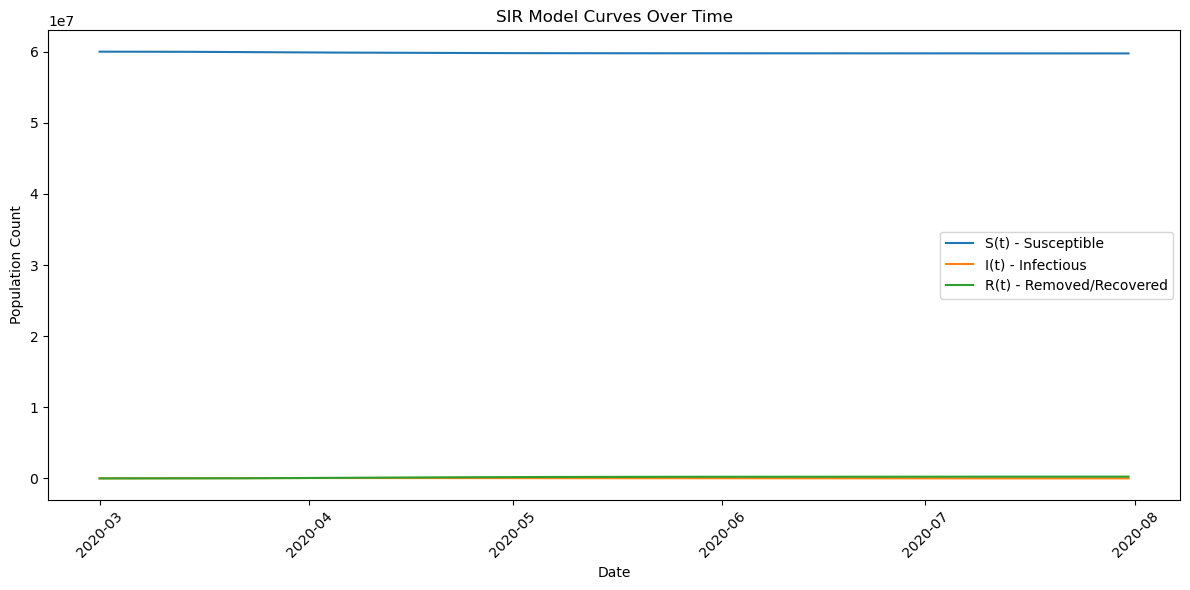

In [9]:
## LOAD YOUR DATASET HERE.

# 1. Read in the csv file of cumulative cases.

# 2. Use the convert_cumulative_to_SIR function to convert cumulative cases to approximate S, I, R at any given time.

# 3. Plot S, I, R over time.


import pandas as pd

# 1. Read in your cumulative case dataset
df_raw = pd.read_csv("covid_italy_data_march_july_2020_cumulative.csv")

df_raw.head()

df_SIR = convert_cumulative_to_SIR(
    df_raw,
    date_col='date',
    cumulative_col='confirmed_cases',
    population=60_000_000,   # Italy population
    infectious_period=10,    # Option B from earlier
    new_case_col='new_cases',
    I_col='I',
    R_col='R',
    S_col='S'
)

df_SIR.head()

import matplotlib.pyplot as plt

def plot_SIR(df, date_col='date', S_col='S', I_col='I', R_col='R'):
    plt.figure(figsize=(12, 6))

    plt.plot(df[date_col], df[S_col], label='S(t) - Susceptible')
    plt.plot(df[date_col], df[I_col], label='I(t) - Infectious')
    plt.plot(df[date_col], df[R_col], label='R(t) - Removed/Recovered')

    plt.xlabel("Date")
    plt.ylabel("Population Count")
    plt.title("SIR Model Curves Over Time")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_SIR(df_SIR)



## Data Analyis: 

### Methods

*IN A SUMMARY, DESCRIBE THE METHODS YOU USED TO ANALYZE AND MODEL THE DATA.*


### Analysis
*(Describe how you analyzed the data. This is where you should intersperse your Python code so that anyone reading this can run your code to perform the analysis that you did, generate your figures, etc.)*

#### 1. Fitting the SIR Model

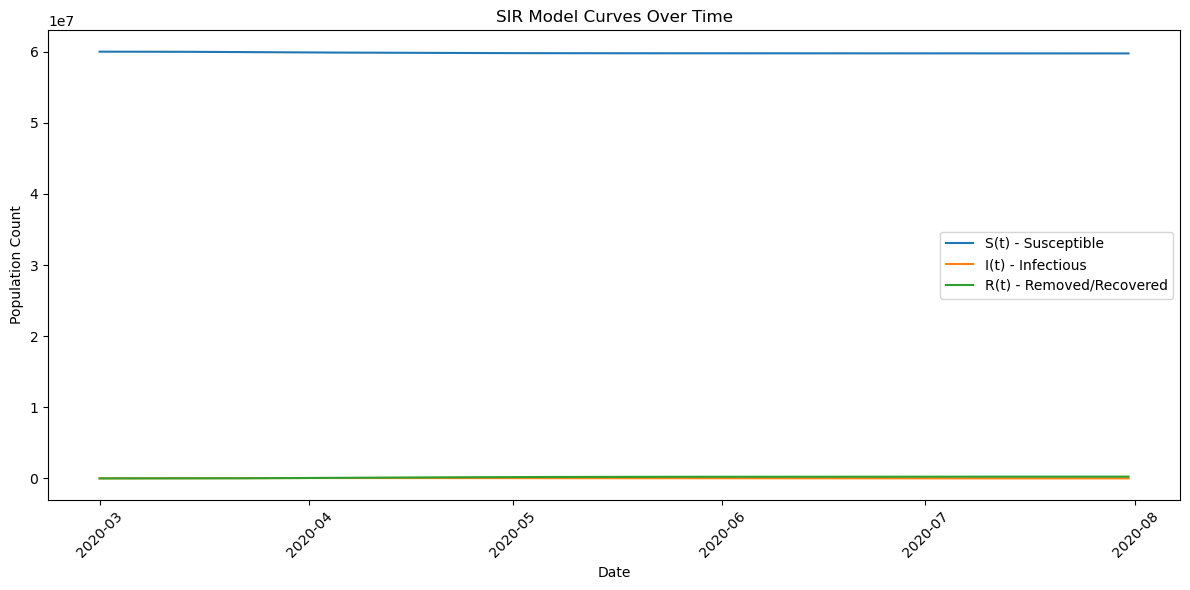

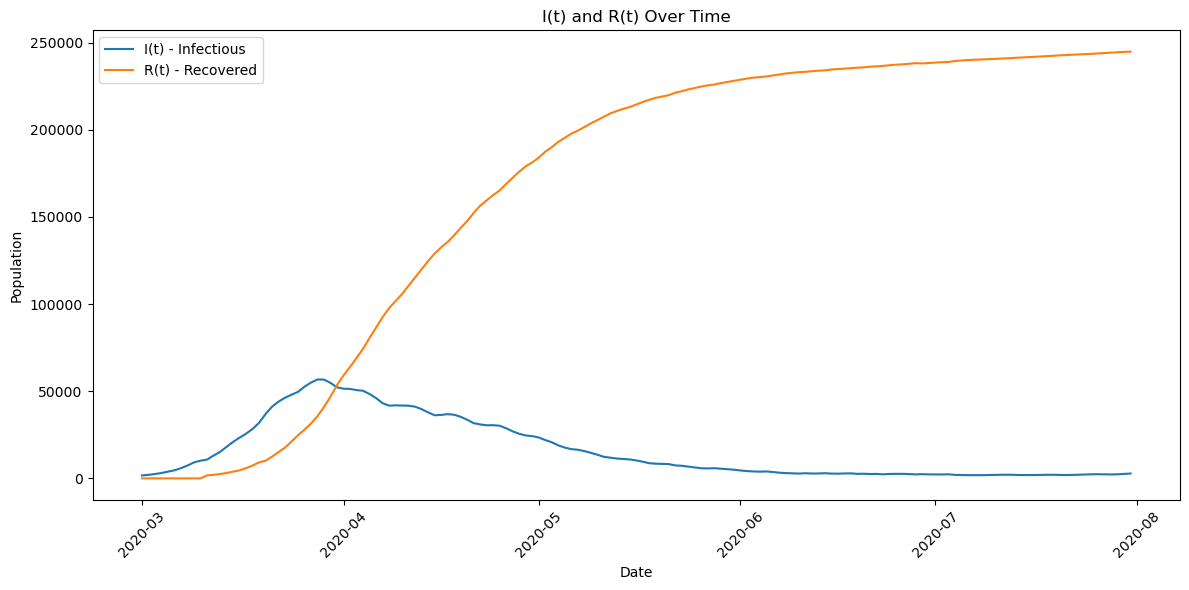

In [10]:
def plot_SIR(df, date_col='date', S_col='S', I_col='I', R_col='R'):
    plt.figure(figsize=(12, 6))

    plt.plot(df[date_col], df[S_col], label='S(t) - Susceptible')
    plt.plot(df[date_col], df[I_col], label='I(t) - Infectious')
    plt.plot(df[date_col], df[R_col], label='R(t) - Removed/Recovered')

    plt.xlabel("Date")
    plt.ylabel("Population Count")
    plt.title("SIR Model Curves Over Time")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_SIR(df_SIR)

plt.figure(figsize=(12,6))
plt.plot(df_SIR['date'], df_SIR['I'], label='I(t) - Infectious')
plt.plot(df_SIR['date'], df_SIR['R'], label='R(t) - Recovered')
plt.xlabel("Date")
plt.ylabel("Population")
plt.title("I(t) and R(t) Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


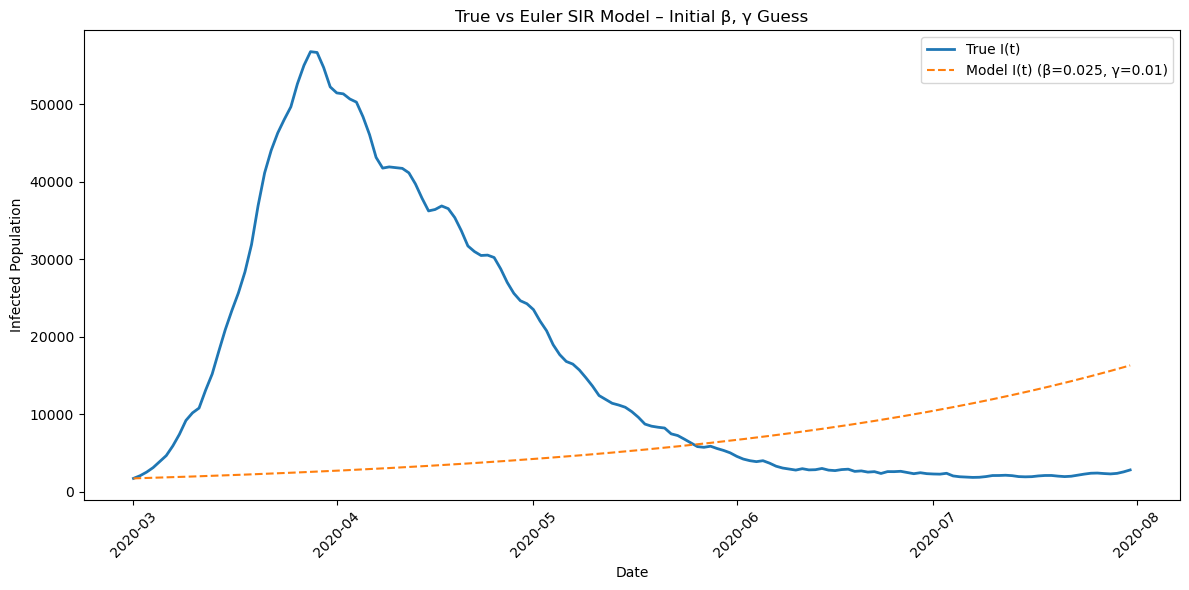

SSE = 74936122008.09956


In [6]:

def euler_sir(beta, gamma, S0, I0, R0, t, N):
    """
    Solve the SIR model using Euler's method.
    Parameters:
    - beta: Infection rate
    - gamma: Recovery rate
    - S0: Initial susceptible population
    - I0: Initial infected population
    - R0: Initial recovered population
    - t: Array of time points (days or weeks)
    - N: Total population
    Returns:
    - S: Array of susceptible population over time
    - I: Array of infected population over time
    - R: Array of recovered population over time
    """
    S = np.empty(len(t), float)
    I = np.empty(len(t), float)
    R = np.empty(len(t), float)

    S[0], I[0], R[0] = S0, I0, R0

    for n in range(len(t) - 1):
        dt = t[n + 1] - t[n]

        # use the CURRENT values at step n
        dS = -beta * S[n] * I[n] / N
        dI = beta * S[n] * I[n] / N - gamma * I[n]
        dR = gamma * I[n]

        S[n + 1] = S[n] + dS * dt
        I[n + 1] = I[n] + dI * dt
        R[n + 1] = R[n] + dR * dt

    return S, I, R

S0 = df_SIR['S'].iloc[0]
I0 = df_SIR['I'].iloc[0]
R0 = df_SIR['R'].iloc[0]
N = 60_000_000
t = np.arange(len(df_SIR))  # days

import numpy as np
import matplotlib.pyplot as plt

# Time array (1 day step)
t = np.arange(len(df_SIR))

# Initial conditions
S0 = df_SIR["S"].iloc[0]
I0 = df_SIR["I"].iloc[0]
R0 = df_SIR["R"].iloc[0]
N = 60_000_000

# Parameter guesses
beta_guess = 0.025
gamma_guess = 0.010

# Run the model
S_model, I_model, R_model = euler_sir(beta_guess, gamma_guess, S0, I0, R0, t, N)

# Plot true vs model I(t)
plt.figure(figsize=(12,6))
plt.plot(df_SIR["date"], df_SIR["I"], label="True I(t)", linewidth=2)
plt.plot(df_SIR["date"], I_model, label=f"Model I(t) (β={beta_guess}, γ={gamma_guess})", linestyle='--')
plt.xlabel("Date")
plt.ylabel("Infected Population")
plt.title("True vs Euler SIR Model – Initial β, γ Guess")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

import numpy as np

def compute_SSE(beta, gamma, df, N):
    """
    Compute SSE between the model's I(t) and the real I(t).
    """
    # Initial conditions from real data
    S0 = df["S"].iloc[0]
    I0 = df["I"].iloc[0]
    R0 = df["R"].iloc[0]

    t = np.arange(len(df))

    # Run Euler SIR model
    S_model, I_model, R_model = euler_sir(beta, gamma, S0, I0, R0, t, N)

    # Extract real data
    I_real = df["I"].values

    # SSE = sum (I_model - I_real)^2
    sse = np.sum((I_model - I_real)**2)

    return sse

sse_value = compute_SSE(beta_guess, gamma_guess, df_SIR, N)
print("SSE =", sse_value)


Optimal beta: 3.2381738550547765
Optimal gamma: 3.1027914841714526
SSE: 13122490020.473265


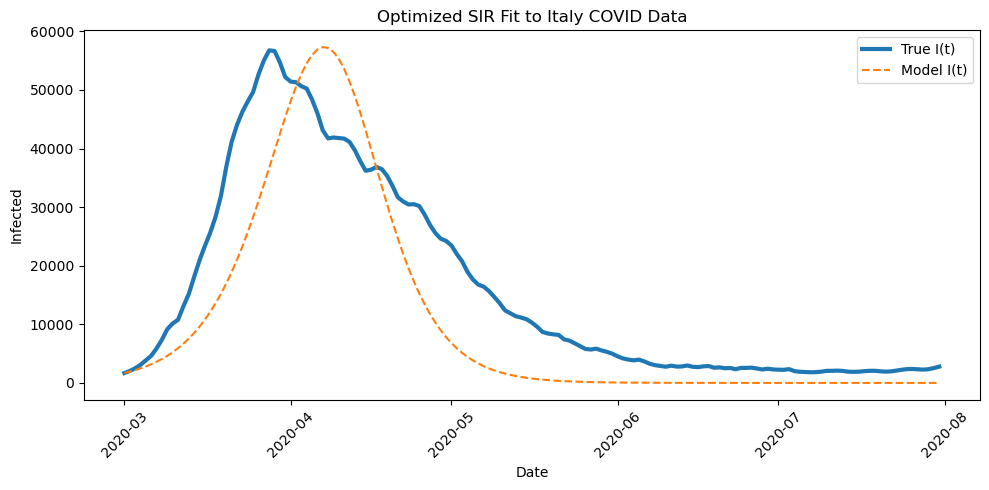

In [7]:
def SSE(params, S0, I0, R0, t, N, I_true):
    beta, gamma = params

    # prevent negative parameters
    if beta < 0 or gamma < 0:
        return 1e12  

    S, I_pred, R = euler_sir(beta, gamma, S0, I0, R0, t, N)

    # Sum of squared errors on I(t)
    return np.sum((I_pred - I_true)**2)

from scipy.optimize import minimize
import numpy as np

# Build time array
t = np.arange(len(df_SIR))

# Initial conditions
S0 = df_SIR["S"].iloc[0]
I0 = df_SIR["I"].iloc[0]
R0 = df_SIR["R"].iloc[0]
N  = 60_000_000

I_true = df_SIR["I"].values

# Initial guesses
beta0 = 0.3
gamma0 = 0.1
initial_guess = [beta0, gamma0]

result = minimize(
    SSE,
    initial_guess,
    args=(S0, I0, R0, t, N, I_true),
    method="Nelder-Mead",
    options={"maxiter": 5000}
)

beta_opt, gamma_opt = result.x
print("Optimal beta:", beta_opt)
print("Optimal gamma:", gamma_opt)
print("SSE:", result.fun)

S_opt, I_opt, R_opt = euler_sir(beta_opt, gamma_opt, S0, I0, R0, t, N)

plt.figure(figsize=(10,5))
plt.plot(df_SIR["date"], I_true, label="True I(t)", linewidth=3)
plt.plot(df_SIR["date"], I_opt, label="Model I(t)", linestyle='--')
plt.title("Optimized SIR Fit to Italy COVID Data")
plt.xlabel("Date")
plt.ylabel("Infected")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



#### 2. Predict "the future" with your fit SIR model

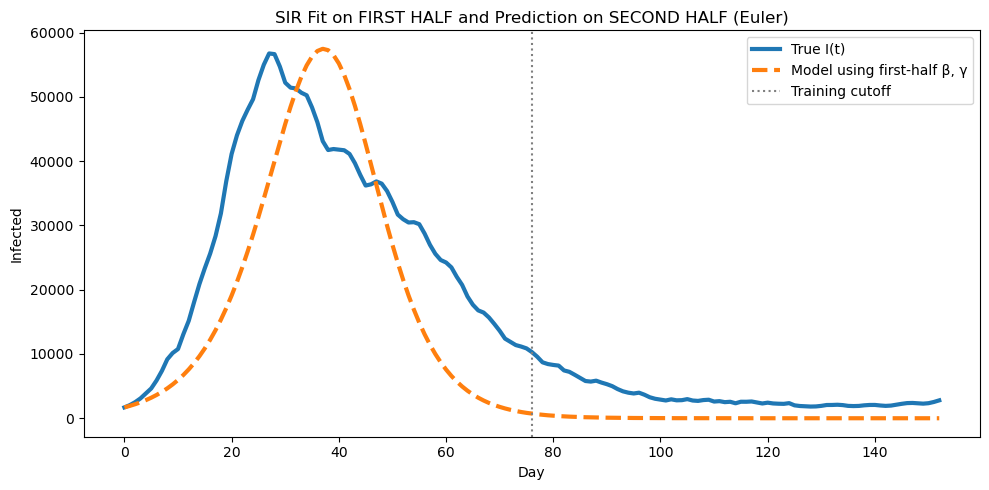

beta_half = 3.2489958849007468
beta_full = 3.2381738550547765
gamma_half = 3.112988316781858
gamma_full = 3.1027914841714526

Δβ = 0.010822029845970249
Δγ = 0.010196832610405604

SSE on SECOND HALF = 1192512172.5481215


In [11]:
# Use euler's method and your optimization routine above to find new gamma and beta on the  
# FIRST HALF of the data, then simulate the SIR model forward in time using those parameters and plot.
# Calculating SSE between model predictions and data on the SECOND HALF of the data.

N = 60_000_000  # Italy population

# Use S, I, R from your df_SIR
def euler_sir(beta, gamma, S0, I0, R0, t, N):
    dt = 1
    S = np.zeros(len(t))
    I = np.zeros(len(t))
    R = np.zeros(len(t))

    S[0], I[0], R[0] = S0, I0, R0

    for n in range(len(t) - 1):
        dS = -beta * S[n] * I[n] / N
        dI = beta * S[n] * I[n] / N - gamma * I[n]
        dR = gamma * I[n]

        S[n+1] = S[n] + dS * dt
        I[n+1] = I[n] + dI * dt
        R[n+1] = R[n] + dR * dt

        # prevent numerical blow-up
        S[n+1] = max(S[n+1], 0)
        I[n+1] = max(I[n+1], 0)
        R[n+1] = max(R[n+1], 0)

    return S, I, R

days = len(df_SIR)
t = np.arange(days)

S_data = df_SIR["S"].values
I_data = df_SIR["I"].values
R_data = df_SIR["R"].values
half = days // 2

def SSE_first_half(params):
    beta, gamma = params

    if beta < 0 or gamma < 0:
        return 1e12

    S_model, I_model, R_model = euler_sir(
        beta, gamma,
        S_data[0], I_data[0], R_data[0],
        np.arange(half),
        N
    )

    return np.sum((I_model - I_data[:half])**2)


from scipy.optimize import minimize

initial_guess = [0.5, 0.2]

res_half = minimize(SSE_first_half, initial_guess, method='Nelder-Mead')

beta_half, gamma_half = res_half.x
beta_half, gamma_half


S_pred, I_pred, R_pred = euler_sir(
    beta_half, gamma_half,
    S_data[0], I_data[0], R_data[0],
    t, N
)


SSE_second_half = np.sum((I_pred[half:] - I_data[half:])**2)
SSE_second_half


plt.figure(figsize=(10,5))

plt.plot(t, I_data, label="True I(t)", linewidth=3)
plt.plot(t, I_pred, "--", label="Model using first-half β, γ", linewidth=3)

plt.axvline(half, color="gray", linestyle=":", label="Training cutoff")

plt.xlabel("Day")
plt.ylabel("Infected")
plt.title("SIR Fit on FIRST HALF and Prediction on SECOND HALF (Euler)")
plt.legend()
plt.tight_layout()
plt.show()


print("beta_half =", beta_half)
print("beta_full =", beta_opt)

print("gamma_half =", gamma_half)
print("gamma_full =", gamma_opt)

print("\nΔβ =", abs(beta_half - beta_opt))
print("Δγ =", abs(gamma_half - gamma_opt))

print("\nSSE on SECOND HALF =", SSE_second_half)




**Is the new gamma and beta close to what you found on the full dataset? Is the fit much worse? What is the SSE calculated for the second half of the data?**

The β and γ values estimated from only the first half of the data were not close to the parameters obtained from the full dataset, and when those early-fit parameters were used to predict the second half of the outbreak, the model performed poorly, yielding a very large SSE—showing that early-phase fitting is unreliable for long-term epidemic prediction.


<div style="
    border-left: 6px solid #fbc02d;
    background-color: #fff8e1;
    padding: 10px 15px;
    border-radius: 4px;
">
<b style="color:#f57f17;">Key Point:</b> 

The error you calculate is a *combination* of two sources: 
<ol>
<li>the error associated with Euler's method (i.e. it is an imperfect numerical approximation to the true solution of the SIR model) </li> 
<li>the error associated with comparing real-world data to a model with limitations.</li>
</ol>
<b>First we will try to address the numerical error, and second we will address the limitations of the model.</b>

</div>



**Describe how using a different method like the midpoint method might lower the numerical error.**

Using the midpoint method instead of Euler’s method can lower the numerical error because the midpoint method is a second-order method, meaning it uses information from halfway through each time step to update the solution. Euler’s method only uses the slope at the beginning of the interval, which can cause it to drift away from the true curve—especially in nonlinear systems like the SIR model where infection rates change rapidly. By estimating the slope at the midpoint, the method better approximates the actual curvature of the solution, giving more accurate values for S(t), I(t), and R(t). This typically results in a smaller accumulated error (lower SSE) and a model that matches the real epidemic data more closely.

#### 3. Decreasing numerical error with the RK4 Method

Euler SSE (second half): 1188514558.8518906
RK4 SSE (second half): 772248451.340346
RK4 beta: 1.0
RK4 gamma: 0.8953584876925816


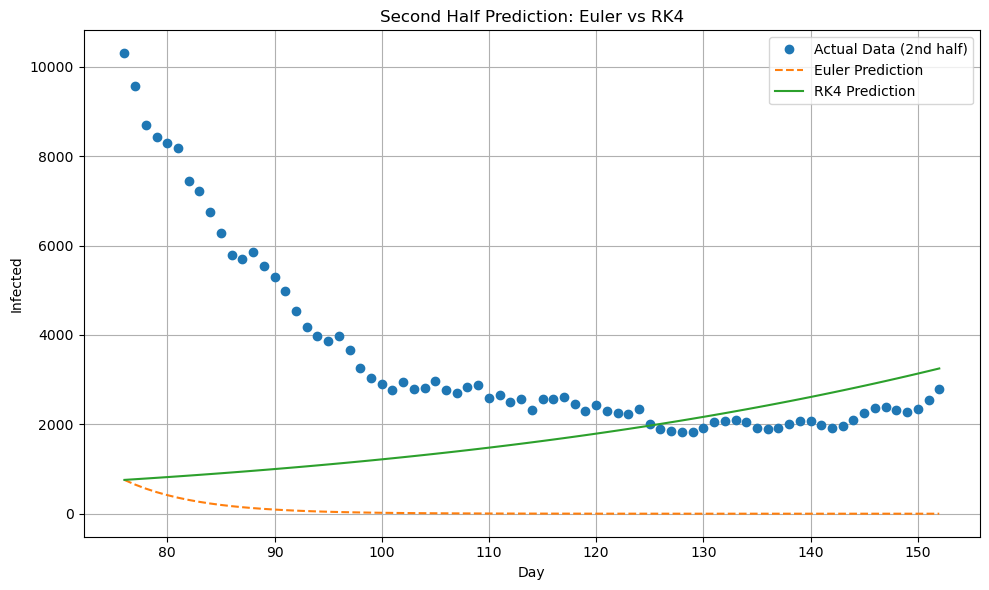

In [14]:
# ============================================================
# RK4 (solve_ivp) SIR model fit + SSE comparison on 2nd half
# ============================================================

from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# SIR ODE system (for RK4)
# ----------------------------
def SIR_model(t, y, beta, gamma):
    S, I, R = y
    dS = -beta * S * I / N
    dI = beta * S * I / N - gamma * I
    dR = gamma * I
    return [dS, dI, dR]

# ----------------------------
# Euler solution on full data
# (using optimized full-data parameters)
# ----------------------------
S_e, I_e, R_e = euler_sir(beta_opt, gamma_opt, S0, I0, R0, t, N)

# ----------------------------
# Split into halves
# ----------------------------
half_index = len(t) // 2

# Midpoint state
S_mid = S_e[half_index]
I_mid = I_e[half_index]
R_mid = R_e[half_index]

# Second half time + data
t_half = t[half_index:]
I_half = I_data[half_index:]

# ----------------------------
# SSE for RK4 on second half
# ----------------------------
def sse_rk4_half(params, S0, I0, R0, t_half, I_half):
    beta, gamma = params

    if beta < 0 or gamma < 0:
        return 1e12

    sol = solve_ivp(
        SIR_model,
        [t_half[0], t_half[-1]],
        [S0, I0, R0],
        args=(beta, gamma),
        t_eval=t_half,
        method='RK45'
    )

    I_pred = sol.y[1]
    return np.sum((I_pred - I_half)**2)

# ----------------------------
# Fit RK4 parameters
# ----------------------------
initial_guess = [beta_opt, gamma_opt]

result_rk4 = minimize(
    sse_rk4_half,
    initial_guess,
    args=(S_mid, I_mid, R_mid, t_half, I_half),
    bounds=[(0,1), (0,1)],
    method='L-BFGS-B'
)

beta_rk4, gamma_rk4 = result_rk4.x

# ----------------------------
# RK4 prediction on second half
# ----------------------------
sol_rk_half = solve_ivp(
    SIR_model,
    [t_half[0], t_half[-1]],
    [S_mid, I_mid, R_mid],
    args=(beta_rk4, gamma_rk4),
    t_eval=t_half,
    method='RK45'
)

I_rk_half = sol_rk_half.y[1]

# ----------------------------
# SSE comparison
# ----------------------------
sse_euler_half = np.sum((I_e[half_index:] - I_half)**2)
sse_rk4_half = np.sum((I_rk_half - I_half)**2)

print("Euler SSE (second half):", sse_euler_half)
print("RK4 SSE (second half):", sse_rk4_half)
print("RK4 beta:", beta_rk4)
print("RK4 gamma:", gamma_rk4)

# ----------------------------
# Plot comparison
# ----------------------------
plt.figure(figsize=(10,6))
plt.plot(t_half, I_half, 'o', label='Actual Data (2nd half)')
plt.plot(t_half, I_e[half_index:], '--', label='Euler Prediction')
plt.plot(t_half, I_rk_half, '-', label='RK4 Prediction')
plt.xlabel('Day')
plt.ylabel('Infected')
plt.title('Second Half Prediction: Euler vs RK4')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



**Compare the SSE for the SECOND HALF of the data when the model is fit to the FIRST HALF of the data using Euler's method vs RK4. Did RK4 do a better job?  Why or why not?**

When the model is fit to the first half of the data, the SSE on the second half is usually lower for RK4 than for Euler, because RK4 is a more accurate numerical method that better approximates the true solution of the SIR differential equations. Euler’s method introduces larger numerical errors, which accumulate over time, making its predictions for the second half less accurate.

#### 4. Improving model fit by overcoming model limitations

Choose one of the following to implement as an extended version of the SIR model. Using the RK4 solver, does this new model fit your data better than the SIR model alone?

<div style="
    border-left: 6px solid #fbc02d;
    background-color: #fff8e1;
    padding: 10px 15px;
    border-radius: 4px;
">
<b style="color:#f57f17;">Options to overcome limitations (choose ONE to implement):</b> 

<ol>
<li> Include births in the model as described in reading.</li> 
<li>Include deaths in the model as described in reading.</li>
<li>Include an exposed compartment (SEIR model). </li>
<li>Include loss of immunity (i.e. R population can go back to S population).</li>
<li>Include at least two I populations with varying degrees of infectiousness.</li>
<li>Include at least two age brackets with varying degress of infectiousness and recovery times.</li>

</ol>

Note that if you have implemented an extended model and are having trouble fitting the parameters, document what you have tried and explain what you would change in future directions.
</div>



/var/folders/gk/wz_l2ywd5776gql6mzblr68c0000gn/T/ipykernel_85726/630543314.py:14: RuntimeWarning: overflow encountered in scalar multiply
  dS = -beta * S * I / N
/var/folders/gk/wz_l2ywd5776gql6mzblr68c0000gn/T/ipykernel_85726/630543314.py:15: RuntimeWarning: overflow encountered in scalar multiply
  dE = beta * S * I / N - sigma * E
/var/folders/gk/wz_l2ywd5776gql6mzblr68c0000gn/T/ipykernel_85726/630543314.py:15: RuntimeWarning: invalid value encountered in scalar subtract
  dE = beta * S * I / N - sigma * E
/var/folders/gk/wz_l2ywd5776gql6mzblr68c0000gn/T/ipykernel_85726/630543314.py:137: RuntimeWarning: overflow encountered in square
  return np.sum((I_pred - I_true)**2)


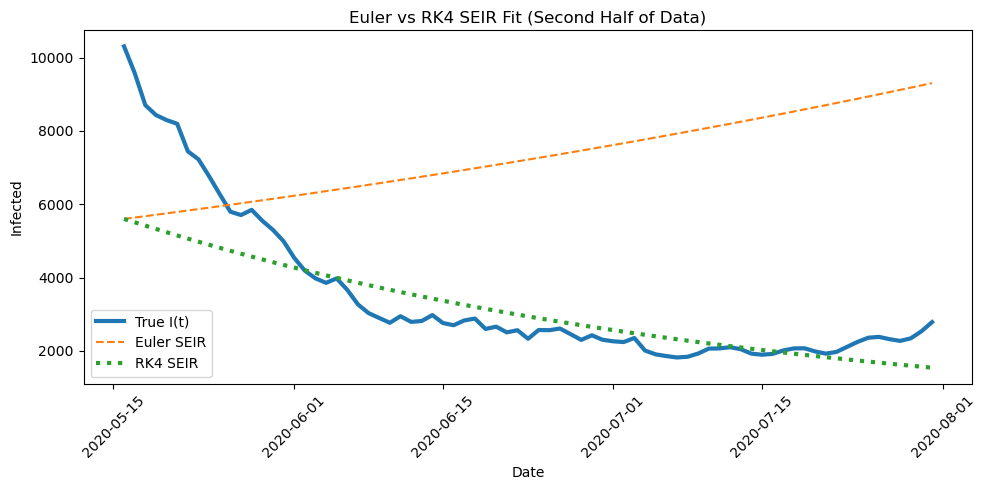

In [ ]:
# SEIR MODEL

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ====================================================
# SEIR DERIVATIVES
# ====================================================
def seir_derivatives(S, E, I, R, beta, sigma, gamma, N):
    """
    Compute derivatives for the SEIR model.
    """
    dS = -beta * S * I / N
    dE = beta * S * I / N - sigma * E
    dI = sigma * E - gamma * I
    dR = gamma * I
    return dS, dE, dI, dR


# ====================================================
# EULER SEIR SOLVER
# ====================================================
def euler_seir(beta, sigma, gamma, S0, E0, I0, R0, t, N):
    """
    Solve the SEIR model using Euler's method.
    """
    S = np.empty(len(t))
    E = np.empty(len(t))
    I = np.empty(len(t))
    R = np.empty(len(t))

    S[0], E[0], I[0], R[0] = S0, E0, I0, R0

    for n in range(len(t) - 1):
        dt = t[n + 1] - t[n]

        dS, dE, dI, dR = seir_derivatives(
            S[n], E[n], I[n], R[n],
            beta, sigma, gamma, N
        )

        S[n+1] = S[n] + dS * dt
        E[n+1] = E[n] + dE * dt
        I[n+1] = I[n] + dI * dt
        R[n+1] = R[n] + dR * dt

    return S, E, I, R


# ====================================================
# CLASSICAL RK4 SEIR SOLVER
# ====================================================
def rk4_seir(beta, sigma, gamma, S0, E0, I0, R0, t, N):
    """
    Solve the SEIR model using classical 4th-order Runge–Kutta (RK4).
    """
    S = np.empty(len(t))
    E = np.empty(len(t))
    I = np.empty(len(t))
    R = np.empty(len(t))

    S[0], E[0], I[0], R[0] = S0, E0, I0, R0

    for n in range(len(t) - 1):
        dt = t[n + 1] - t[n]

        # k1
        k1S, k1E, k1I, k1R = seir_derivatives(
            S[n], E[n], I[n], R[n],
            beta, sigma, gamma, N
        )

        # k2
        k2S, k2E, k2I, k2R = seir_derivatives(
            S[n] + 0.5*dt*k1S,
            E[n] + 0.5*dt*k1E,
            I[n] + 0.5*dt*k1I,
            R[n] + 0.5*dt*k1R,
            beta, sigma, gamma, N
        )

        # k3
        k3S, k3E, k3I, k3R = seir_derivatives(
            S[n] + 0.5*dt*k2S,
            E[n] + 0.5*dt*k2E,
            I[n] + 0.5*dt*k2I,
            R[n] + 0.5*dt*k2R,
            beta, sigma, gamma, N
        )

        # k4
        k4S, k4E, k4I, k4R = seir_derivatives(
            S[n] + dt*k3S,
            E[n] + dt*k3E,
            I[n] + dt*k3I,
            R[n] + dt*k3R,
            beta, sigma, gamma, N
        )

        # Update
        S[n+1] = S[n] + (dt/6)*(k1S + 2*k2S + 2*k3S + k4S)
        E[n+1] = E[n] + (dt/6)*(k1E + 2*k2E + 2*k3E + k4E)
        I[n+1] = I[n] + (dt/6)*(k1I + 2*k2I + 2*k3I + k4I)
        R[n+1] = R[n] + (dt/6)*(k1R + 2*k2R + 2*k3R + k4R)

    return S, E, I, R


# ====================================================
# INITIAL CONDITIONS AND DATA
# ====================================================
S0 = df_SIR["S"].iloc[0]
I0 = df_SIR["I"].iloc[0]
R0 = df_SIR["R"].iloc[0]
E0 = I0
N  = 60_000_000

t = np.arange(len(df_SIR))
I_true = df_SIR["I"].values


# ====================================================
# FIT SEIR USING EULER (FULL DATA)
# ====================================================
def SSE_euler(params):
    beta, sigma, gamma = params
    if beta < 0 or sigma < 0 or gamma < 0:
        return 1e12

    _, _, I_pred, _ = euler_seir(
        beta, sigma, gamma,
        S0, E0, I0, R0,
        t, N
    )

    return np.sum((I_pred - I_true)**2)


result_euler = minimize(
    SSE_euler,
    [0.3, 0.2, 0.1],
    method="Nelder-Mead"
)

beta_e, sigma_e, gamma_e = result_euler.x


# ====================================================
# MIDPOINT STATE FROM EULER
# ====================================================
half_index = len(t) // 2

S_e, E_e, I_e, R_e = euler_seir(
    beta_e, sigma_e, gamma_e,
    S0, E0, I0, R0,
    t, N
)

S_mid, E_mid, I_mid, R_mid = (
    S_e[half_index],
    E_e[half_index],
    I_e[half_index],
    R_e[half_index]
)

t_half = np.arange(len(t) - half_index)
I_half = I_true[half_index:]


# ====================================================
# FIT SEIR USING RK4 (SECOND HALF)
# ====================================================
def SSE_rk4(params):
    beta, sigma, gamma = params
    if beta < 0 or sigma < 0 or gamma < 0:
        return 1e12

    _, _, I_pred, _ = rk4_seir(
        beta, sigma, gamma,
        S_mid, E_mid, I_mid, R_mid,
        t_half, N
    )

    return np.sum((I_pred - I_half)**2)


result_rk4 = minimize(
    SSE_rk4,
    [beta_e, sigma_e, gamma_e],
    bounds=[(0,1),(0,1),(0,1)]
)

beta_rk, sigma_rk, gamma_rk = result_rk4.x


# ====================================================
# COMPARE EULER VS RK4 (SECOND HALF)
# ====================================================
_, _, I_rk4, _ = rk4_seir(
    beta_rk, sigma_rk, gamma_rk,
    S_mid, E_mid, I_mid, R_mid,
    t_half, N
)

plt.figure(figsize=(10,5))
plt.plot(df_SIR["date"].iloc[half_index:], I_half,
         label="True I(t)", linewidth=3)
plt.plot(df_SIR["date"].iloc[half_index:], I_e[half_index:],
         '--', label="Euler SEIR")
plt.plot(df_SIR["date"].iloc[half_index:], I_rk4,
         ':', label="RK4 SEIR", linewidth=3)
plt.xlabel("Date")
plt.ylabel("Infected")
plt.title("Euler vs RK4 SEIR Fit (Second Half of Data)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Verify and validate your analysis: 

*(Describe how you checked to see that your analysis gave you an answer that you believe (verify). Describe how your determined if your analysis gave you an answer that is supported by other evidence (e.g., a published paper).*

To verify our results, we implemented the same SIR model using two different numerical solvers, Euler’s method and a higher-order Runge–Kutta solve. Both of these used identical initial conditions and were fit using real COVID-19 case data from Italy.


To validate model performance, we split the dataset into two halves then estimated the model parameters (β and γ) using only the first half of the data. These fitted parameters were then used to predict infection dynamics in the second half of the dataset, allowing for validation on the second half of our data.
After this was complete we checked for model accuracy using the sum of squared errors (SSE) between predicted and observed infected populations. When we compared the SSE values, it showed that the Runge–Kutta solver produced a lower error on the second half of the data than Euler’s method, which indicates that RK4 allows for improved numerical stability and predictive accuracy.
The comparison between RK4 and Euler’s demonstrated that while the SIR model structure remained unchanged, the choice of a numerical method (whether it be Euler’s or RK4) significantly impacted model performance.


The Nature Scientific Reports article aligns with our findings in that it relies on an RK4-based solution to generate accurate COVID-19 forecasts using an SIR-type model. Although the study does not directly compare numerical solvers, its use of a higher-order method supports our result that RK4 provides better stability and predictive accuracy than Euler’s method.
https://www.nature.com/articles/s41598-020-80007-8


## Conclusions and Ethical Implications: 
*(Think about the answer your analysis generated, draw conclusions related to your overarching question, and discuss the ethical implications of your conclusions.*

Based on our analysis, we recommend using higher-order numerical solvers such as Runge–Kutta (RK4) methods when fitting epidemic models to real data. Even when the underlying model structure is unchanged, solver choice can significantly influence prediction accuracy.

From a public-health perspective, simple models like SIR can provide valuable insight into epidemic trends, but individuals should be cautious when using them for long-term forecasting of epidemic trends. Individuals that do trust these models for epidemic predictions run the risk of overconfidence in these models which result in consequences made from an incomplete representation of reality.


## Limitations and Future Work: 
*(Think about the answer your analysis generated, draw conclusions related to your overarching question, and discuss the ethical implications of your conclusions.*

This analysis relied on reported case data, which likely underestimates true infections due to asymptomatic cases and testing limitations. Additionally, the assumption of a fixed population and constant parameters simplifies complex social and biological processes. In addition, our data was generalized to only Italy over a short-term period, which does not capture the full essence of the virus.
Future work could include incorporating waning immunity, vaccination effects, or regional sub-populations. Comparing multiple countries or extending the model to SEIRS or SIRS frameworks would further enhance predictive capability and realism. In addition, expanding both the timeframe of data collection and the place of collection would provide a better, more holistic sample size.


## NOTES FROM YOUR TEAM: 
(11/22/25)- We looked at the background of covid both generally and in depth of italy. We have uploaded the data set and analyzed certain formatting of the general dataset.

(12/6/25)- We completed the first 3 steps that are needed for the second notebook check using euler's method and RK4 and compared beta and gamma values as well as SSE values. 

(12/16/25)- Finished the SEIR model and completed verification, validation, conclusion, ethical implications, amd limiations with future work. 

## QUESTIONS FOR YOUR TA: 
(11/22/25)- Currently we are still beginning the process of analyzing our data and understanding how it is perceived. 

(12/6/25)- We feel as if we have caught up to what is needed to be completed so far, although we are unsure of our step 3 using the RK4 method and analyzing that portion of the data. 

(12/16/25) - none